In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

Here we use CRP binding at the lacZYA promoter as a case study for simple activation.

## 0. Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [5]:
promoter.find(rnap_site)

74

In [6]:
promoter.find(crp_site)

41

In [7]:
#crp_site = 'ATTAATGTGAGTTAGCTCACTCATT'
#crp_emat_raw = pd.read_csv('../../data/energy_matrices/2011_lacZ_MG1655_M9glucose_na_mut1_4bins_CRP_emat_mean.csv')
#crp_emat_raw = crp_emat_raw[['A', 'C', 'G', 'T']]
#crp_emat = crp_emat_raw.to_numpy().T
#crp_emat = tregs.simulate.fix_wt(crp_emat, crp_site)

In [8]:
crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T
crp_emat

array([[0.  , 0.  , 0.  , 0.21, 0.13, 1.47, 1.67, 0.98, 2.53, 0.  , 0.82,
        0.51, 0.44, 0.  , 0.57, 0.  , 1.85, 1.91, 0.  , 0.83, 0.  , 0.  ,
        0.76, 0.17, 0.77, 0.57],
       [0.55, 0.92, 0.96, 1.04, 0.46, 0.72, 2.38, 1.27, 2.77, 0.92, 0.  ,
        0.  , 0.22, 0.36, 0.24, 0.73, 1.62, 0.  , 1.55, 0.  , 2.18, 0.72,
        1.15, 0.65, 0.38, 0.4 ],
       [0.45, 0.65, 0.72, 1.06, 0.32, 1.78, 0.  , 1.45, 0.  , 1.48, 0.47,
        0.37, 0.38, 0.12, 0.  , 0.55, 1.05, 2.77, 1.24, 2.21, 1.01, 0.45,
        1.56, 0.81, 0.91, 0.52],
       [0.19, 0.31, 0.11, 0.  , 0.  , 0.  , 1.47, 0.  , 1.94, 1.67, 0.1 ,
        0.57, 0.  , 0.41, 0.42, 0.9 , 0.  , 2.44, 1.01, 1.41, 2.  , 0.26,
        0.  , 0.  , 0.  , 0.  ]])

In [9]:
crp_emat.shape

(4, 26)

In [10]:
len(crp_site)

26

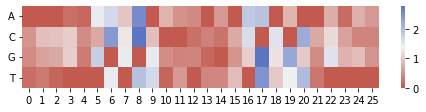

In [11]:
fig, ax = plt.subplots(figsize=(8, 1.5))

div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
sns.heatmap(crp_emat, cmap=div_colors, ax=ax)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

In [12]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

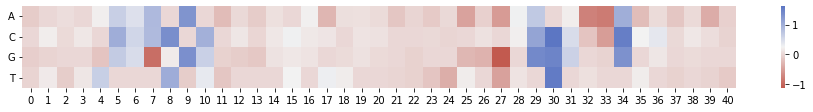

In [13]:
fig, ax = plt.subplots(figsize=(16, 1.5))
sns.heatmap(rnap_emat.T, cmap=div_colors, ax=ax)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360)
plt.show()

## Building synthetic dataset

In [29]:
def simact_pbound(p_seq, a_seq, p_emat, a_emat, n_p, n_a, n_NS,
                  ep_wt=0, ea_wt=0, e_ap=0):

    p = (n_p / n_NS) * tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    a = (n_a / n_NS) * tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)
    w = np.exp(-e_ap)

    pbound = (p + a * p * w) / (1 + a + p + a * p * w)

    return pbound


def simact_helper(mutants, rnap_start, rnap_end, act_start, act_end,
                  rnap_emat, act_emat, n_p, n_a, n_NS,
                  ep_wt=0, ea_wt=0, e_ap=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        act_mut = mut[act_start:act_end].upper()
        rv['pbound'] = simact_pbound(rnap_mut, act_mut, rnap_emat, act_emat,
                                     n_p, n_a, n_NS,
                                     ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)
        l_tr.append(rv)
    df = pd.DataFrame.from_records(l_tr)

    return df


def simact(wtseq, rnap_wtseq, act_wtseq,
           rnap_emat, act_emat, n_p, n_a, n_NS,
           ep_wt=0, ea_wt=0, e_ap=0,
           num_mutants=10000, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(
                                    wtseq,
                                    rate=0.1,
                                    num_mutants=num_mutants,
                                    number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    act_start, act_end = tregs.seq_utils.find_binding_site(wtseq, act_wtseq)

    df = simact_helper(mutants, rnap_start, rnap_end, act_start, act_end,
                       rnap_emat, act_emat, n_p, n_a, n_NS,
                       ep_wt, ea_wt, e_ap)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df))
    df['ct_0'] = dna_cnt
    df = df[df.ct_0 != 0.0]

    df['ct_1'] = 1 + df['ct_0'] * df['pbound'] * scaling_factor
    df['ct_1'] = df['ct_1'].astype(int)
    
    df['ct_0'] = df['ct_0'].astype(float)
    df['ct_1'] = df['ct_1'].astype(float)
    df['norm_ct_1'] = df['ct_1'] / df['ct_0']

    return df

In [30]:
n_NS = len(genome)
n_p = 4000
n_a = 50
ep_wt = -5
ea_wt = -1
e_ap = -2

In [31]:
df = simact(promoter, rnap_site, crp_site,
           rnap_emat, crp_emat, n_p, n_a, n_NS,
           ep_wt=ep_wt, ea_wt=ea_wt, e_ap=e_ap)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

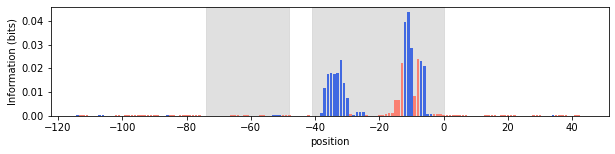

In [32]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

rnap_start, rnap_end = tregs.seq_utils.find_binding_site(promoter, rnap_site)
act_start, act_end = tregs.seq_utils.find_binding_site(promoter, crp_site)
ax.axvspan(rnap_start-115, rnap_end-115, alpha=0.7, color='lightgray')
ax.axvspan(act_start-115, act_end-115, alpha=0.7, color='lightgray')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()